In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np

# %config InlineBackend.figure_format='retina'

In [2]:
import utils.load_grid as lg
from utils.load_cmaps import *

In [3]:
pgrid_dir = "data/scratch/pgrid_earth_gridtest_9"
cases = lg.get_cases(pgrid_dir)

In [4]:
# Collect netcdf files
endt = np.array([lg.get_nc_years(c)[-1] for c in cases])
endn = [lg.read_nc(c+"/data/%d_atm.nc" % endt[i]) for i,c in enumerate(cases)]
endp = np.array([endn[i]["psurf"] for i in range(len(cases))])
stts = lg.get_statuses(pgrid_dir)
ncases = len(cases)

# Configuration variables
cfgs = [lg.read_config(c) for c in cases]
keys = cfgs[0].keys()
cvars = {}
for k in keys:
    values = []
    for i in range(ncases):
        v = cfgs[i][k]
        if lg.is_float(v):
            values.append(v)
    if len(values) > 0:
        cvars[k] = np.array(values)

# Helpfiles
helps = []
for c in cases:
    helps.append(lg.read_helpfile(c))
for v in lg.volatile_species:
    v_arr = []
    for h in helps:
        v_arr.append(h.iloc[-1][v+"_mr"])
    cvars[v+"_surf"] = np.array(v_arr)

In [10]:
def make_s2d(x,x_lbl, y,y_lbl, z,z_lbl, control, plot_casenums=False, plot_controls=False, logz=False):
    # Make plot
    x_plt = np.array([], dtype=float) # x variable
    y_plt = np.array([], dtype=float) # y variable 
    z_plt = np.array([], dtype=float) # z variable
    c_plt = np.array([], dtype=int)   # case number
    g_plt = np.array([], dtype=bool)  # case finished with success? (good)
    g_plt = np.array([], dtype=bool)  # case finished with failure? (bad)
    for i in range(len(x)):
        skip_this = False
        for k in control.keys():
            if k in cvars.keys():
                if not np.isclose(cvars[k][i],control[k]):
                    skip_this = True
                    break
        if skip_this:
            continue 
        x_plt = np.append(x_plt, x[i])
        y_plt = np.append(y_plt, y[i])
        z_plt = np.append(z_plt, z[i])
        c_plt = np.append(c_plt, i)
        g_plt = np.append(g_plt, bool( 10 <= stts[i] <= 19))
    if len(z_plt) == 0:
        print("WARNING: No data left after applying control variables!")
        return

    b_plt = np.invert(g_plt)
        
        
    fig,ax = plt.subplots(1,1, figsize=(5,4))

    if not logz:
        norm = mpl.colors.Normalize(vmin=np.amin(z_plt), vmax=np.amax(z_plt))
    else:
        norm = mpl.colors.LogNorm(vmin=np.amin(z_plt), vmax=np.amax(z_plt))
    cmap = sci_colormaps['batlow']
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])

    ax.scatter(x_plt[g_plt], y_plt[g_plt], c=z_plt[g_plt], norm=norm, cmap=cmap, marker='s', s=240)
    ax.scatter(x_plt[b_plt], y_plt[b_plt], c=z_plt[b_plt], norm=norm, cmap=cmap, marker='x', s=240)

    if plot_casenums:
        for i in range(len(x_plt)):
            ax.text(x_plt[i],y_plt[i],c_plt[i],fontsize=7, color='magenta', horizontalalignment='center', verticalalignment='center')

    if plot_controls:
        control_str = "Control variables:\n"
        for k in control.keys():
            control_str += "  %s=%g\n" % (k,control[k])
        control_str = control_str[:-1]
        axt = ax.text(0.05, 0.95, control_str, 
                horizontalalignment='left', verticalalignment='top', transform=ax.transAxes, fontsize=10)
        axt.set_bbox(dict(facecolor='white', alpha=0.5, linewidth=0))

    ax.set_xlabel(x_lbl)
    ax.set_ylabel(y_lbl)
    ax.set_yscale("log")

    cax = make_axes_locatable(ax).append_axes('right', size='5%', pad=0.05)
    fig.colorbar(sm, cax=cax, orientation='vertical').set_label(z_lbl) 

    plt.show()

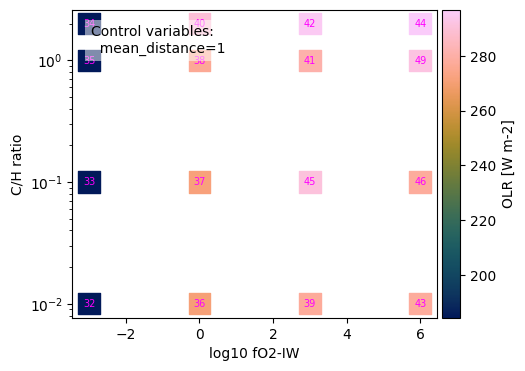

In [19]:
# Variables
x = cvars["fO2_shift_IW"];  x_lbl = "log10 fO2-IW"
y = cvars["CH_ratio"];      y_lbl = "C/H ratio"

# z = endp * 1.0e-5; z_lbl = "Surface pressure [bar]"
# z = endt * 1.0e-3;  z_lbl = "Termination [kyr]"
# z = cvars["CO2_surf"] * 100; z_lbl = "CO2 VMR [%]"
z = np.array([ endn[i]["fl_U_LW"][0] for i in range(ncases) ]); z_lbl = "OLR [W m-2]"
control = {"mean_distance":1.0}

plot_controls = True
plot_casenums = True
logz = False

make_s2d(x,x_lbl, y,y_lbl, z,z_lbl, control, plot_casenums=plot_casenums, plot_controls=plot_controls, logz=logz)
